# San Francisco Airbnb Price Prediction Using Supervised Learning Algorithms

## The data analysis below uses Airbnb data of San Francisco in March 2018

In [1]:
#Import packages

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
#Read SF listings from March 2018 csv file to a Pandas DataFrame

url_listing = '/Users/forheart/Dropbox/Data Scientist/Capstone Project 1/2018_march_listings.csv.gz'
df = pd.read_csv(url_listing, sep=',')
pd.set_option('display.max_columns', None)

## Data Preprocessing

In [3]:
# Drop non-relavant, redundant, empty or not useful columns
df = df.drop(columns=['id', 'listing_url', 'scrape_id', 'last_scraped', 'experiences_offered', 'thumbnail_url', 'medium_url', 'picture_url', 
'xl_picture_url', 'host_url', 'host_name', 'host_location', 'host_acceptance_rate', 'host_thumbnail_url', 'host_picture_url', 'host_since',
'host_neighbourhood', 'host_total_listings_count', 'host_verifications', 'street', 'neighbourhood', 'weekly_price', 'monthly_price', 'square_feet',
'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'host_response_time', 
'longitude', 'calendar_last_scraped', 'jurisdiction_names', 'has_availability', 'first_review', 'last_review', 'license', 'host_id', 'calendar_updated',])

In [4]:
# Create a list of column names for columns that can be categorical
Category = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact', 'property_type', 'room_type',
          'bed_type', 'requires_license', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 
          'require_guest_profile_picture', 'require_guest_phone_verification', 'neighbourhood_cleansed']

# Define the lambda function: categorize
categorize= lambda x: x.astype('category')

# Convert df[Category] to a categorical type
df[Category] = df[Category].apply(categorize, axis=0)

# Check the converted dtypes
print(df[Category].dtypes)

host_is_superhost                   category
host_has_profile_pic                category
host_identity_verified              category
is_location_exact                   category
property_type                       category
room_type                           category
bed_type                            category
requires_license                    category
instant_bookable                    category
is_business_travel_ready            category
cancellation_policy                 category
require_guest_profile_picture       category
require_guest_phone_verification    category
neighbourhood_cleansed              category
dtype: object


In [5]:
# Create a list of column names for columns that are binary categorical
binary_cat = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact', 'requires_license', 
              'instant_bookable', 'is_business_travel_ready', 'require_guest_profile_picture', 'require_guest_phone_verification']

# Change the entries of "t" ("true") or "f" ("faulse") to 1 and 0 in binary categorical columns
for column in binary_cat:
    df[column] = df[column].map({'t': 1, 'f': 0})

# Change the bed_type colume to binary categorical column too
df['bed_type'] = df['bed_type'].eq('Real Bed').mul(1)

In [6]:
# Create only numeric columns right now. This will include the categorical columns since they can be converted later to numericals.
numerics = ['int64', 'float64', 'category']
df_num = df.select_dtypes(include=numerics)
df_others = df.select_dtypes(exclude=numerics)
df_others.columns

Index(['name', 'summary', 'space', 'description', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'host_about', 'host_response_rate', 'amenities', 'price',
       'security_deposit', 'cleaning_fee', 'extra_people'],
      dtype='object')

In [7]:
# We can see that in the "object" dtype columns, there are still many numerical columns that were stored as strings. 
# So convert these columns to numerical columns as well.

# Create a list of column names for columns to be converted from strings to numbers

strtonum = ['price', 'security_deposit', 'cleaning_fee','extra_people']

for column in strtonum:
    df[column] = df[column].str.replace('$', '')
    df[column] = df[column].str.replace(',', '')
    df[column] = df[column].astype(float)

df['host_response_rate'] = df['host_response_rate'].str.strip('%').astype('float')/100

# Update the numeric and text dataframe.
df_num = df.select_dtypes(include=numerics)
df_others = df.select_dtypes(exclude=numerics)

# Take a look at the df_others again, they are all text data, save the names of these text columns for later use.
TEXT = ['name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 
        'interaction', 'house_rules', 'host_about', 'amenities']

In [8]:
# Check missing data in each column
df_num.isnull().sum()

host_response_rate                   394
host_is_superhost                     28
host_listings_count                   28
host_has_profile_pic                  28
host_identity_verified                28
neighbourhood_cleansed                 0
is_location_exact                      0
property_type                          0
room_type                              0
accommodates                           0
bathrooms                             23
bedrooms                               0
beds                                   6
bed_type                               0
price                                  0
security_deposit                    1129
cleaning_fee                         477
guests_included                        0
extra_people                           0
minimum_nights                         0
maximum_nights                         0
availability_30                        0
availability_60                        0
availability_90                        0
availability_365

In [9]:
# There are many missing values in the numerical dataframe. 
# For numerical columns, we can replace NaN in some columns with 0, some with 1, depending on the variables

# Fill the missing values in the host_listings_count column with 1.
df_num.loc[:,'host_listings_count'] = df_num['host_listings_count'].fillna(value=1, inplace=False)

# Fill the missing values in the rest of columns with 0.
fillna_col = ['host_response_rate', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'bathrooms', 
              'security_deposit', 'cleaning_fee', 'reviews_per_month', 'beds', 'review_scores_rating', 'review_scores_accuracy', 
              'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_checkin', 'review_scores_communication', 
              'review_scores_location', 'review_scores_value']
df_num[fillna_col] = df_num[fillna_col].fillna(value=0, inplace=False)

# Now there is non missing values in the df_num dataframe.

/Users/forheart/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/forheart/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [10]:
# Combine some of the neighbourhoods into larger realestate distrcits
# Open neighbourhood CSV 
link = '/Users/forheart/Dropbox/Data Scientist/Capstone Project 1/Districts.csv'
df_district = pd.read_csv(link, index_col=False)
df_district.head()

,neighbourhood,government district,real estate districts
0,Bayview,10,10.0
1,Bernal Heights,9,9.0
2,Castro/Upper Market,8,5.0
3,Chinatown,3,8.0
4,Crocker Amazon,11,10.0


In [11]:
# This dataframe shows what the real estate districts each neighbourhood is in.

# There are 11 official government districts, and 10 inofficial real estate districts.
df_district = df_district.dropna(axis=0, how='any')
df_district['government district'] = df_district['government district'].astype(str)
df_num['neighbourhood'] = df_num['neighbourhood_cleansed']
df_num = pd.merge(df_district, df_num, on='neighbourhood')

# Use only the government districts here, and delete the other neighbourhood or district clumns and rename 
# the "government district" column to simply "district", and convert the data type to category
df_num = df_num.drop(columns = ['neighbourhood', 'neighbourhood_cleansed', 'real estate districts'])

df_num = df_num.rename(columns={'government district':'district'})

df_num['district'] = df_num['district'].astype('category')

/Users/forheart/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
# Now all categorical columns can be converted to numerical columns by using the get_dummies method
df_with_dummies = pd.get_dummies(df_num, columns = ['district', 'property_type', 'room_type', 'cancellation_policy'] )
df_with_dummies.head()

,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,district_1,district_10,district_11,district_2,district_3,district_4,district_5,district_6,district_7,district_8,district_9,property_type_Aparthotel,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Castle,property_type_Condominium,property_type_Dorm,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_In-law,property_type_Loft,property_type_Other,property_type_Resort,property_type_Serviced apartment,property_type_Timeshare,property_type_Tiny house,property_type_Townhouse,property_type_Treehouse,property_type_Vacation home,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
0,1.0,0.0,1.0,1.0,0.0,1,4,1.0,2,2.0,1,120.0,300.0,150.0,2,10.0,30,730,3,33,63,338,8,93.0,10.0,9.0,10.0,10.0,9.0,10.0,1,0,0,0,0,1,0.10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,1.0,0.0,1.0,1.0,1.0,1,5,1.5,1,2.0,1,112.0,0.0,12.0,1,10.0,2,1125,5,23,53,53,338,88.0,9.0,9.0,10.0,10.0,8.0,9.0,1,0,0,0,0,1,4.25,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,0.8,0.0,1.0,1.0,1.0,1,2,1.5,2,1.0,1,79.0,400.0,125.0,1,40.0,30,120,26,56,86,361,7,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1,0,0,0,1,0.69,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
3,1.0,1.0,1.0,1.0,1.0,1,2,1.5,1,1.0,1,90.0,0.0,25.0,1,0.0,3,7,3,10,19,183,228,99.0,10.0,10.0,10.0,10.0,9.0,10.0,1,0,0,1,1,1,3.38,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,1.0,1.0,4.0,1.0,1.0,1,1,1.5,1,1.0,1,56.0,375.0,65.0,1,0.0,1,220,12,37,58,242,37,94.0,9.0,9.0,10.0,10.0,8.0,9.0,1,0,0,0,0,3,0.63,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


There are extreme numbers for this column. I will use the 97.5 percentile to cap those values.

In [13]:
percentile = np.percentile(df_with_dummies.minimum_nights, [1, 99])

In [14]:
df_with_dummies['minimum_nights'][df_with_dummies.minimum_nights > percentile[1]] = percentile[1]

/Users/forheart/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
percentile1 = np.percentile(df_with_dummies.maximum_nights, [1, 99])
df_with_dummies['maximum_nights'][df_with_dummies.maximum_nights > percentile1[1]] = percentile1[1]

/Users/forheart/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
len(df_with_dummies)

4804

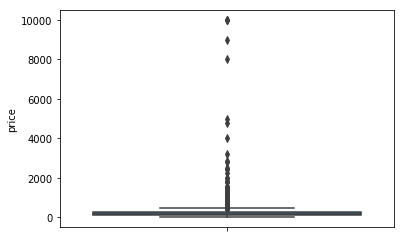

In [18]:
# Check outliers for the target variable "price"
sns.boxplot(y='price', data=df_with_dummies)
plt.show()

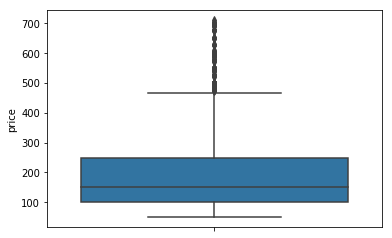

In [21]:
# The plot shows that there are many outliers in the distribution of the target variable price.

# Get rid of the outliers.
percentile2 = np.percentile(df_with_dummies.price, [2.5, 97.5])
newdf = df_with_dummies[(df_with_dummies.price > percentile2[0]) & (df_with_dummies.price < percentile2[1])]

sns.boxplot(y='price', data=newdf)

In [22]:
len(newdf)

4557

In [23]:
# Prep the feature variables and target variable
# Use the numerical features only for now

X = newdf.drop('price', axis=1).values
y = newdf['price'].values

# Split into training and test set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [66]:
newdf.columns.values

array(['host_response_rate', 'host_is_superhost', 'host_listings_count',
       'host_has_profile_pic', 'host_identity_verified',
       'is_location_exact', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'requires_license', 'instant_bookable',
       'is_business_travel_ready', 'require_guest_profile_picture',
       'require_guest_phone_verification',
       'calculated_host_listings_count', 'reviews_per_month',
       'district_1', 'district_10', 'district_11', 'district_2',
       'district_3', 'district_4', 'district_5', 

## Linear Regression

In [24]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [25]:
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [26]:
# The R2 of the training set
lr.score(X_train, y_train)

0.6408284127749262

In [27]:
y_pred = lr.predict(X_test)
# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [28]:
# The R2 of the test set
lr.score(X_test, y_test)

0.6212299290481336

In [29]:
print("Root Mean Squared Error: {}".format(rmse))

Root Mean Squared Error: 76.15076580098278


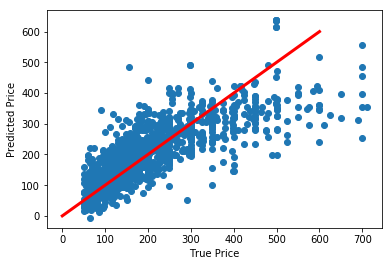

In [30]:
plt.scatter(y_test, y_pred)
plt.plot([0,600], [0, 600], linewidth=3, color='red')
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.show()

#### The above figure shows that linear regression here tends to underestimate the price for the expensive listings.

#### Try 5-fold cross-validation using ShuffleSplit


In [31]:
cv_score = cross_val_score(lr, X_train, y_train, cv=5)
cv_score

array([0.64329215, 0.60764696, 0.56652396, 0.61427633, 0.58285007])

In [32]:
np.mean(cv_score)

0.6029178952430992

## Lasso Regression

In [33]:
# Try reagularized regression: Lasso Regression
from sklearn.linear_model import Lasso

# Start with a random alpha
lasso = Lasso(alpha=0.5, normalize=True)
lasso.fit(X_train, y_train)

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [34]:
# Using lasso coefficients to select the most important features

lasso_coef = lasso.coef_
df_feature = newdf.drop('price', axis=1)
df_feature.columns.values[np.abs(lasso_coef) != 0]

array(['accommodates', 'cleaning_fee', 'room_type_Entire home/apt'],
      dtype=object)

#### Lasso coefficients showed that the number of people the listing accommodates, cleaning_fee, and whether it is an entire home are the three most important features for predicting price.

In [35]:
y_pred = lasso.predict(X_test)
# R2 for the training set.
lasso.score(X_train, y_train)

0.40213807363025705

In [36]:
# R2 for the testing set.
lasso.score(X_test, y_test)

0.42366483459452703

In [37]:
# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

93.9342575370826

#### Hyperparameter tuning with GridSearchCV

In [39]:
# hyperparameter tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV

In [40]:
# Setup the hyperparameter grid
alpha_space = np.logspace(-2, 2, num=20)
param_grid = {'alpha': alpha_space}
grid = GridSearchCV(lasso, param_grid, cv=5)

grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1.00000e-02, 1.62378e-02, 2.63665e-02, 4.28133e-02, 6.95193e-02,
       1.12884e-01, 1.83298e-01, 2.97635e-01, 4.83293e-01, 7.84760e-01,
       1.27427e+00, 2.06914e+00, 3.35982e+00, 5.45559e+00, 8.85867e+00,
       1.43845e+01, 2.33572e+01, 3.79269e+01, 6.15848e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [41]:
y_pred = grid.predict(X_test)
# R2 for the trainig set
print('The R2 for the training set is ', grid.score(X_train, y_train))
# R2 for the test set
print('The R2 for the testing set is ', grid.score(X_test, y_test))
# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('The root mean squared error is $', rmse)
print('The best hyperparameter is ', grid.best_params_)

The R2 for the training set is  0.6341243321439884
The R2 for the testing set is  0.6306969645633541
The root mean squared error is $ 75.1930820256336
The best hyperparameter is  {'alpha': 0.01}


#### The RMSE for the regulated Lasso Regression is so far the lowest using GridSearchCV, which is $75.19

## Ridge Regression

In [44]:
# Try Ridge regression using GridSearchCV
from sklearn.linear_model import Ridge

In [46]:
# Setup the array of alphas
alpha_space = np.logspace(-4, 0, 50)

# Create a ridge regressor: ridge
ridge = Ridge(normalize=True)

param_grid = {'alpha': alpha_space}
grid = GridSearchCV(ridge, param_grid, cv=5)

grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1.00000e-04, 1.20679e-04, 1.45635e-04, 1.75751e-04, 2.12095e-04,
       2.55955e-04, 3.08884e-04, 3.72759e-04, 4.49843e-04, 5.42868e-04,
       6.55129e-04, 7.90604e-04, 9.54095e-04, 1.15140e-03, 1.38950e-03,
       1.67683e-03, 2.02359e-03, 2.44205e-03, 2.94705e-03, 3.55... 3.23746e-01, 3.90694e-01,
       4.71487e-01, 5.68987e-01, 6.86649e-01, 8.28643e-01, 1.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [47]:
y_pred = grid.predict(X_test)
# R2 for the trainig set
print('The R2 for the training set is ', grid.score(X_train, y_train))
# R2 for the test set
print('The R2 for the testing set is ', grid.score(X_test, y_test))
# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('The root mean squared error is $', rmse)
print('The best hyperparameter is ', grid.best_params_)

The R2 for the training set is  0.6373563739288903
The R2 for the testing set is  0.628789435813389
The root mean squared error is $ 75.3870260409418
The best hyperparameter is  {'alpha': 0.02811768697974228}


### ElasticNet

In [48]:
# Try ElasticNet
from sklearn.linear_model import ElasticNet

In [49]:
# Setup the array of l1_ratio
l1_space = np.linspace(0.1, 1, 5)
alpha_space = np.logspace(-3, 0, 4)

# Create a ridge regressor: ridge
elastic = ElasticNet(normalize=True)

param_grid = {'alpha': alpha_space, 'l1_ratio': l1_space}

grid = GridSearchCV(elastic, param_grid, cv=5)

In [50]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=True, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([0.001, 0.01 , 0.1  , 1.   ]), 'l1_ratio': array([0.1  , 0.325, 0.55 , 0.775, 1.   ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [51]:
y_pred = grid.predict(X_test)
# R2 for the trainig set
print('The R2 for the training set is ', grid.score(X_train, y_train))
# R2 for the test set
print('The R2 for the testing set is ', grid.score(X_test, y_test))
# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('The root mean squared error is $', rmse)
print('The best hyperparameter is ', grid.best_params_)

The R2 for the training set is  0.6341243321439884
The R2 for the testing set is  0.6306969645633541
The root mean squared error is $ 75.1930820256336
The best hyperparameter is  {'alpha': 0.01, 'l1_ratio': 1.0}


#### The best l1_ratio is 1, which means that it is better to use a lasso regression instead of a ridge regression. And the RMSE for the ElasticNet regression here is exactly the same with the Lasso result. This indicted that a lasso regression is better than a ridge regression here.

## Gradient Boosting Machine

In [52]:
from sklearn.ensemble import GradientBoostingRegressor

In [53]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [54]:
y_pred = gbr.predict(X_test)
# R2 for the trainig set
print('The R2 for the training set is ', gbr.score(X_train, y_train))
# R2 for the test set
print('The R2 for the testing set is ', gbr.score(X_test, y_test))
# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('The root mean squared error is $', rmse)

The R2 for the training set is  0.777262605133796
The R2 for the testing set is  0.7002212789458835
The root mean squared error is $ 67.7464977543593


### Partial Dependence Plots

In [86]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from mpl_toolkits.mplot3d import Axes3D

In [87]:
names = newdf.drop(columns=['price']).columns.values

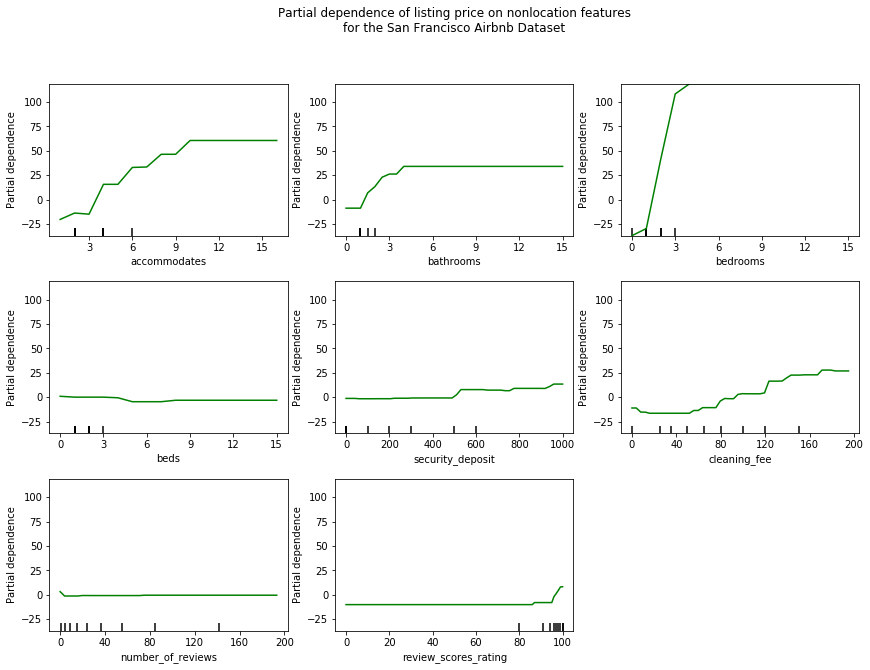

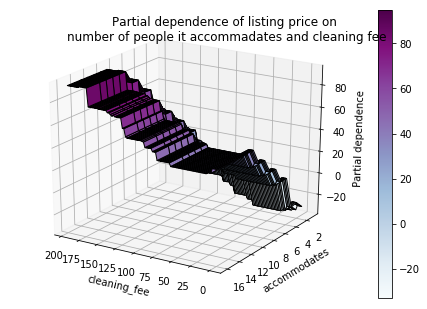

In [91]:
# Get important features from the dataframe
features = [6, 7, 8, 9, 11, 12, 21, 22]

fig, axs = plot_partial_dependence(gbr, X_train, features, feature_names=names, grid_resolution=50)

plt.title('Partial dependence of listing price on nonlocation features\n'
                 'for the San Francisco Airbnb Dataset', y=3.9)
plt.subplots_adjust(left=0.125, bottom=0.1, right=2, top=2, wspace=0.2)  
fig = plt.figure()
    
target_feature = (12, 6)
pdp, axes = partial_dependence(gbr, target_feature, X=X_train, grid_resolution=100)
XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(names[target_feature[0]])
ax.set_ylabel(names[target_feature[1]])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle('Partial dependence of listing price on \n'
                 'number of people it accommadates and cleaning fee')
plt.subplots_adjust(top=1.2)

plt.show()

#### The above Partial Dependence Plots shows the listing price is in linear relationship with number of people it accommadates, bathrooms, bedrooms, security deposit, cleaning fee within a certain range of these variables. The listing price does not change much with the number of reviews much. And the listing price increases with review rating score.

#### The two-way partial dependence plot shows the dependence of listing price on joint values of # accommadates and cleaning fee. 

### Varianble Importance

In [92]:
# The Recursive Feature Elimination (RFE) method is a feature selection approach. It works by recursively removing attributes 
# and building a model on those attributes that remain.

from sklearn.feature_selection import RFE

# create a gradient boosting regressor
model = GradientBoostingRegressor()
# create the RFE model and select 3 attributes
rfe = RFE(model, 3)
rfe = rfe.fit(X_train, y_train)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False  True False False False False False
  True False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False]
[25 55  7 64 61 59  1 11  3 31 34  2  1 10  1  4 36 19 30  8  6 22  9 24
 76 75 79 26 40 51 56 15 63 54 16  5 42 33 18 17 12 20 47 13 29 35 71 69
 23 72 45 77 49 68 65 66 38 74 57 53 73 41 48 67 32 28 39 62 14 58 43 70
 60 21 52 37 44 50 46 78 27]


In [93]:
names[rfe.support_]

array(['accommodates', 'cleaning_fee', 'extra_people'], dtype=object)

#### The Recursive Feature Elimination selected three important features and ranked them according to their importance. RFE selected "accommodates" (the number of people it accommodates), "cleaning_fee", and "extra_people" (how much extra people would charge) as the three most important features to predict the price of the listing. 

## Random Forest Regression

In [55]:
from sklearn.ensemble import RandomForestRegressor

In [59]:
rf = RandomForestRegressor(max_depth=10, n_estimators=300)

In [60]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [61]:
y_pred = rf.predict(X_test)
# R2 for the trainig set
print('The R2 for the training set is ', rf.score(X_train, y_train))
# R2 for the test set
print('The R2 for the testing set is ', rf.score(X_test, y_test))
# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('The root mean squared error is $', rmse)

The R2 for the training set is  0.8800130145555476
The R2 for the testing set is  0.6764473764817156
The root mean squared error is $ 70.38156349971817
